## Code Modules & Helpful Functions

In [ ]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl
import h5py,tensorflow as tf
from tensorflow import image as timage
import tensorflow_datasets as tfds
import tensorflow_hub as th

In [ ]:
def resize_display(x_train,y_train,
                   x_test,y_test,pixels):
    x_train=np.array(timage.resize(x_train,[pixels,pixels]))
    x_test=np.array(timage.resize(x_test,[pixels,pixels]))
    N=len(y_train); shuffle_ids=np.arange(N)
    np.random.RandomState(12).shuffle(shuffle_ids)
    x_train,y_train=x_train[shuffle_ids],y_train[shuffle_ids]
    N=len(y_test); shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x_test,y_test=x_test[shuffle_ids],y_test[shuffle_ids]
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type'])
    display(df)    
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test]]

## Data

In [ ]:
splits=['train[:80%]','train[80%:]']
tfds.disable_progress_bar()
(raw_train,raw_test),metadata=\
tfds.load('cats_vs_dogs:4.0.0',split=splits,
          with_info=True,as_supervised=True)

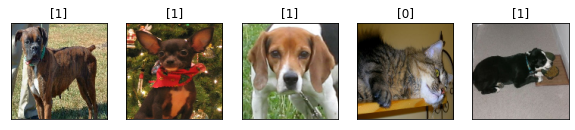

In [ ]:
s=128; ntest=4652
ntrain=23262-ntest
x_test=np.zeros((ntest,s,s,3),dtype='float32')
y_test=np.zeros((ntest,1),dtype='int32')
x_train=np.zeros((ntrain,s,s,3),dtype='float32')
y_train=np.zeros((ntrain,1),dtype='int32')
i=0
for f,t in raw_test.take(ntest):
    f=timage.resize(f,[s,s])
    x_test[i,:]=f.numpy()/255
    y_test[i,:]=t; i+=1
i=0
for f,t in raw_train.take(ntrain):
    f=timage.resize(f,[s,s])
    x_train[i,:]=f.numpy()/255
    y_train[i,:]=t; i+=1
fig=pl.figure(figsize=(10,4))   
for i in range(5):    
    ax=fig.add_subplot(1,5,i+1,\
    xticks=[],yticks=[],title=y_train[i])
    ax.imshow((x_train[i]));

## NN Examples

In [ ]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',
                  metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [ ]:
[handle_base,pixels]=["mobilenet_v2_075_96",96]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)
fw='weights.best.hdf5'

In [ ]:
[[x_train,x_valid,x_test],
 [y_train,y_valid,y_test]]=\
resize_display(x_train,y_train,x_test,y_test,pixels)

,train,valid,test
image shape,"(18610, 96, 96, 3)","(2326, 96, 96, 3)","(2326, 96, 96, 3)"
image type,float32,float32,float32
label shape,"(18610, 1)","(2326, 1)","(2326, 1)"
label type,int32,int32,int32


In [ ]:
model=premodel(pixels,2048,mhandle,1,
               'sigmoid','binary_crossentropy')
history=model.fit(x=x_train,y=y_train,batch_size=128,
                  epochs=5,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              1382064   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2623488   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 4,007,601
Trainable params: 3,980,961
Non-trainable params: 26,640
_________________________________________________________________


None

Epoch 1/5
146/146 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.9260
Epoch 00001: val_loss improved from inf to 0.48081, saving model to weights.best.hdf5
146/146 [==============================] - 566s 4s/step - loss: 0.2494 - accuracy: 0.9260 - val_loss: 0.4808 - val_accuracy: 0.9196 - lr: 0.0010
Epoch 2/5
146/146 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9659
Epoch 00002: val_loss improved from 0.48081 to 0.22944, saving model to weights.best.hdf5
146/146 [==============================] - 554s 4s/step - loss: 0.1473 - accuracy: 0.9659 - val_loss: 0.2294 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 3/5
146/146 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.9747
Epoch 00003: val_loss did not improve from 0.22944
146/146 [==============================] - 544s 4s/step - loss: 0.1241 - accuracy: 0.9747 - val_loss: 0.2438 - val_accuracy: 0.9471 - lr: 0.0010
Epoch 4/5
146/146 [==============================] - 

In [ ]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

73/73 [==============================] - 12s 161ms/step - loss: 0.1701 - accuracy: 0.9596


[0.17013631761074066, 0.9595872759819031]

In [ ]:
[handle_base,pixels]=["mobilenet_v1_100_128",128]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)

In [ ]:
x_train=timage.resize(x_train,[pixels,pixels])
x_valid=timage.resize(x_valid,[pixels,pixels])
x_test=timage.resize(x_test,[pixels,pixels])

In [ ]:
model=premodel(pixels,2048,mhandle,1,
               'sigmoid','binary_crossentropy')
history=model.fit(x=x_train,y=y_train,batch_size=128,
                  epochs=5,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1024)              3228864   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2099200   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 5,330,113
Trainable params: 5,308,225
Non-trainable params: 21,888
_________________________________________________________________


None

Epoch 1/5
146/146 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.9424
Epoch 00001: val_loss improved from inf to 0.46817, saving model to weights.best.hdf5
146/146 [==============================] - 1190s 8s/step - loss: 0.2862 - accuracy: 0.9424 - val_loss: 0.4682 - val_accuracy: 0.8861 - lr: 0.0010
Epoch 2/5
146/146 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.9768
Epoch 00002: val_loss improved from 0.46817 to 0.25472, saving model to weights.best.hdf5
146/146 [==============================] - 1194s 8s/step - loss: 0.1895 - accuracy: 0.9768 - val_loss: 0.2547 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 3/5
146/146 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9832
Epoch 00003: val_loss did not improve from 0.25472
146/146 [==============================] - 1176s 8s/step - loss: 0.1752 - accuracy: 0.9832 - val_loss: 1.1935 - val_accuracy: 0.8306 - lr: 0.0010
Epoch 4/5
146/146 [==============================]

In [ ]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

73/73 [==============================] - 28s 380ms/step - loss: 0.2410 - accuracy: 0.9531


[0.24100328981876373, 0.9531384110450745]